In [24]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import MissingValuesFiller, Scaler
from darts.datasets import EnergyDataset
from darts.metrics import r2_score
from darts.models import NBEATSModel
from darts.utils.callbacks import TFMProgressBar

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)


def generate_torch_kwargs():
    # run torch models on CPU, and disable progress bars for all model stages except training.
    return {
        "pl_trainer_kwargs": {
            "accelerator": "cpu",
            "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
        }
    }

In [4]:
def display_forecast(pred_series, ts_transformed, forecast_type, start_date=None):
    plt.figure(figsize=(8, 5))
    if start_date:
        ts_transformed = ts_transformed.drop_before(start_date)
    ts_transformed.univariate_component(0).plot(label="actual")
    pred_series.plot(label=("historic " + forecast_type + " forecasts"))
    plt.title(f"R2: {r2_score(ts_transformed.univariate_component(0), pred_series)}")
    plt.legend()

In [5]:
%reload_ext autoreload
%autoreload 2

Text(0.5, 1.0, 'Hourly generation hydro run-of-river and poundage')

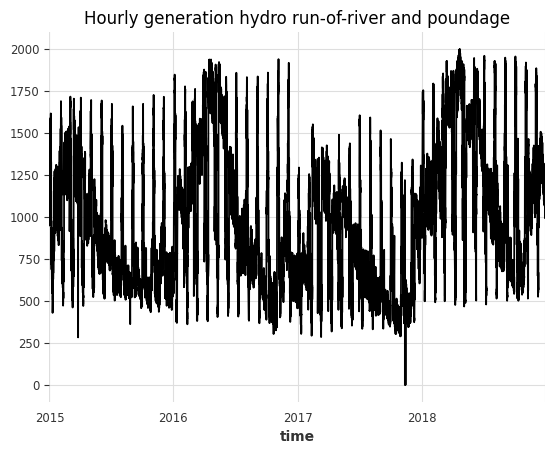

In [6]:
df = EnergyDataset().load().to_dataframe()
df["generation hydro run-of-river and poundage"].plot()
plt.title("Hourly generation hydro run-of-river and poundage")

In [15]:
df.columns

Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil coal-derived gas', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation fossil oil shale', 'generation fossil peat',
       'generation geothermal', 'generation hydro pumped storage aggregated',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation marine',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste', 'generation wind offshore',
       'generation wind onshore', 'forecast solar day ahead',
       'forecast wind offshore eday ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual'],
      dtype='object')

Text(0.5, 1.0, 'Daily generation hydro run-of-river and poundage')

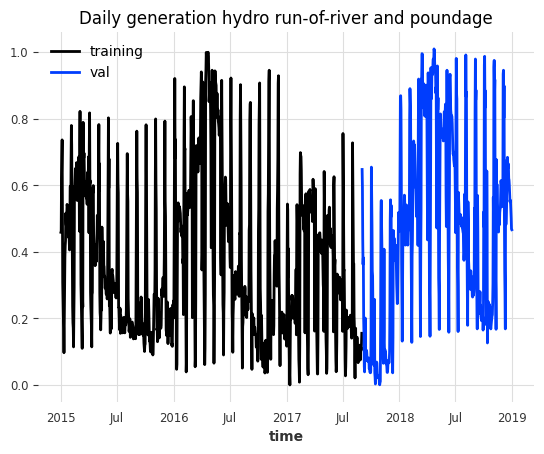

In [18]:
df_day_avg = df.groupby(df.index.astype(str).str.split(" ").str[0]).mean().reset_index()
filler = MissingValuesFiller()
scaler = Scaler()
series = filler.transform(
    TimeSeries.from_dataframe(
        df_day_avg, "time", ["generation hydro run-of-river and poundage"]
    )
).astype(np.float32)

train, val = series.split_after(pd.Timestamp("20170901"))

train_scaled = scaler.fit_transform(train)
val_scaled = scaler.transform(val)
series_scaled = scaler.transform(series)


train_scaled.plot(label="training")
val_scaled.plot(label="val")
plt.title("Daily generation hydro run-of-river and poundage")

In [19]:
model_name = "nbeats_run"
model_nbeats = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=7,
    generic_architecture=True,
    num_stacks=10,
    num_blocks=1,
    num_layers=4,
    layer_widths=512,
    n_epochs=100,
    nr_epochs_val_period=1,
    batch_size=800,
    random_state=42,
    model_name=model_name,
    save_checkpoints=True,
    force_reset=True,
    **generate_torch_kwargs(),
)

In [20]:
model_nbeats.fit(train_scaled, val_series=val_scaled)

Training: 0it [00:00, ?it/s]

NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=10, num_blocks=1, num_layers=4, layer_widths=512, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=30, output_chunk_length=7, n_epochs=100, nr_epochs_val_period=1, batch_size=800, random_state=42, model_name=nbeats_run, save_checkpoints=True, force_reset=True, pl_trainer_kwargs={'accelerator': 'cpu', 'callbacks': [<darts.utils.callbacks.TFMProgressBar object at 0x15c5342f0>]})

In [21]:
model_nbeats = NBEATSModel.load_from_checkpoint(model_name=model_name, best=True)

In [22]:
pred_series = model_nbeats.historical_forecasts(
    series_scaled,
    start=val.start_time(),
    forecast_horizon=7,
    stride=7,
    last_points_only=False,
    retrain=False,
    verbose=True,
)
pred_series = concatenate(pred_series)

Generating TimeSeries:   0%|          | 0/69 [00:00<?, ?it/s]

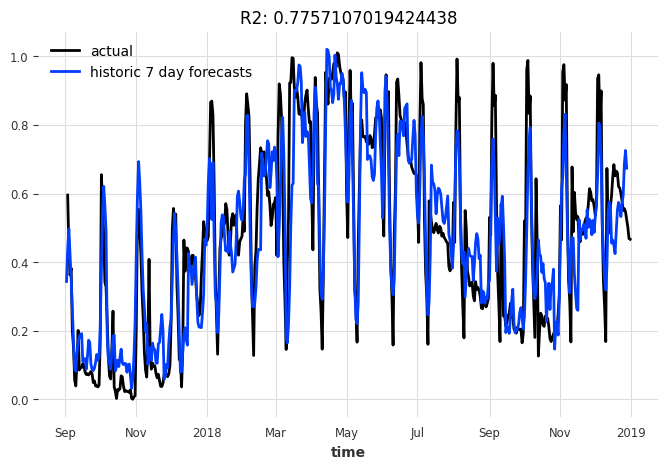

In [23]:
display_forecast(
    pred_series,
    series_scaled,
    "7 day",
    start_date=val.start_time(),
)